#                                             COMPUTING ASSIGNMENT - 3

In this assignment, we aim to explore the concept of Convolutional Neural Networks (CNNs) and their suitability for image classification tasks. We will understand the significance of automatic feature learning in image classification and how CNNs excel in utilizing spatial relationships within images.
To Do:
    a. You will have to to successfully run this notebook and understand the steps.
    b. Make any modifications/additions to demonstrate that the model trained correctly, by using an image from the 'Test' dataset and verify that it was correctly classified.
    c. Take an image of a your own handwritten digit (possibly in a 5cm x 5cm sheet) and verify if the model is able to classify it correctly. If it fails, justify the reason.
    d. Take images of a specific digit, one from the 'train' and 'test' set. Extract the SIFT features for these digits. Compare them using their SIFT features and verify if they match. Justify.
    e. Create a copy of this notebook and now use the CIFAR10 dataset and modify the template (keep the basic model same as 'Sequential', but can make other changes) as necessary to perform classification on this dataset. Show that the trained model is able to classify the objects from the given 'Train' set. Does it work for your own image (not necessarily in the dataset) ?

### A basic CNN architecture

CNNs are a class of deep learning models designed to automatically and adaptively learn spatial hierarchies of features from input data, particularly images. They are characterized by their ability to learn directly from pixel data with minimal preprocessing. A CNN employs spatial convolution for processing. This operation calculates a sum of products between pixel values and a set of kernel weights, applied at each spatial location in the input image. The result at each location is a scalar value, analogous to the output of a neuron in a fully connected neural network. Adding a bias and applying an activation function completes the analogy with fully connected networks.

# ![cnn.png](attachment:cnn.png)

A typical CNN architecture consists of several layers:

Convolutional Layer: These layers apply convolution operations to the input data, which involves sliding a small filter (kernel) over the input to detect patterns and features.

Pooling Layer: Pooling layers reduce the spatial dimensions of the input by taking the maximum or average value within a small window. This helps reduce the computational load and focuses on the most important features.

Fully Connected Layer (Dense Layer): These layers are traditional neural network layers that take the output of the previous layers and produce the final classification or regression output.

### Visualizing feature maps after convolution and pooling operations

We will try to visualize the features in each layer of a CNN using the MNIST dataset

In [ ]:
#make sure libraries like TensorFlow, Keras, NumPy, and Matplotlib are installed
#if not, uncomment the following line
#pip install tensorflow keras numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import cv2

In [ ]:
# Confusion matrix plot
#Evaluation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # if normalize:
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    # else:
        # print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Next, we load the MNIST dataset and view a few samples from it

In [ ]:
x_train.shape

(60000, 28, 28)

11490434/11490434 [==============================] - 0s 0us/step
Shape of the images (28, 28)


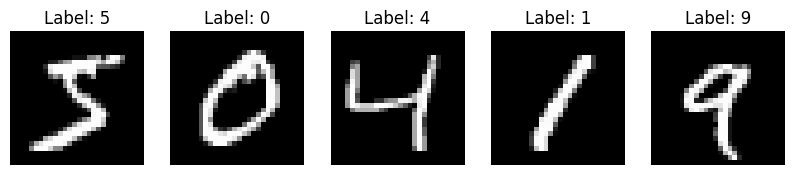

In [ ]:
#Load the MNIST dataset and preprocess it
(x_train_og, y_train), (x_test_og, y_test) = mnist.load_data()
x_train = x_train_og.reshape((-1, 28, 28, 1))
x_test = x_test_og.reshape((-1, 28, 28, 1))
x_train = x_train_og.astype('float32') / 255.0
x_test = x_test_og.astype('float32') / 255.0

print("Shape of the images", x_train[0].shape)
#Display a few sample images
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

Now, let us visualize how convolution and pooling operations affect the sizes and structure of feature maps. We load an image, create a 5x5 receptive field (convolution kernel), and perform convolution on the image. After convolution, we apply max-pooling with a 2x2 neighborhood to obtain the pooled feature map

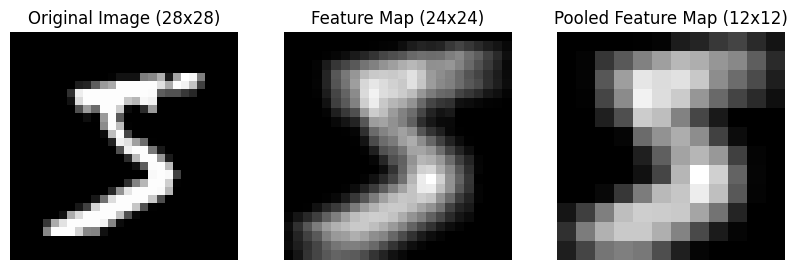

In [ ]:
image = x_train[0]

#Create a random 5x5 receptive field
receptive_field = np.random.rand(5, 5)

feature_map = np.zeros((24, 24))  # Output feature map size after convolution (28-5+1)x(28-5+1)

for i in range(24):
    for j in range(24):
        feature_map[i, j] = np.sum(image[i:i+5, j:j+5] * receptive_field) #Perform convolution

#Perform max-pooling with a 2x2 neighborhood
pooled_feature_map = np.zeros((12, 12))

for i in range(0, 24, 2):
    for j in range(0, 24, 2):
        pooled_feature_map[i//2, j//2] = np.max(feature_map[i:i+2, j:j+2])

#Visualize the image, feature map, and pooled feature map
plt.figure(figsize=(10, 4))

plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title("Original Image (28x28)")
plt.axis('off')

plt.subplot(132)
plt.imshow(feature_map, cmap='gray')
plt.title("Feature Map (24x24)")
plt.axis('off')

plt.subplot(133)
plt.imshow(pooled_feature_map, cmap='gray')
plt.title("Pooled Feature Map (12x12)")
plt.axis('off')

plt.show()


Let us visualize how an input image propagates through the CNN and visualize the feature maps at different layers of the network. To do so, we create a simple CNN model with 2 convolutional layers and pooling.

1/1 [==============================] - 0s 302ms/step


<ipython-input-5-71bade343a4a>:50: RuntimeWarning: invalid value encountered in divide
  x /= x.std()  # Divide by standard deviation for scaling


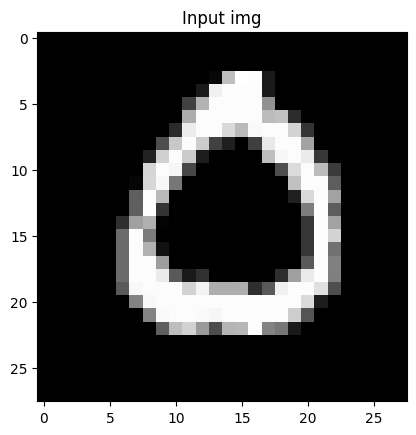

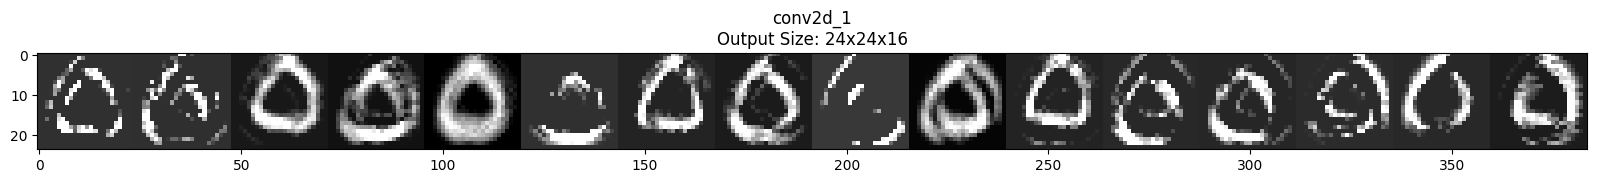

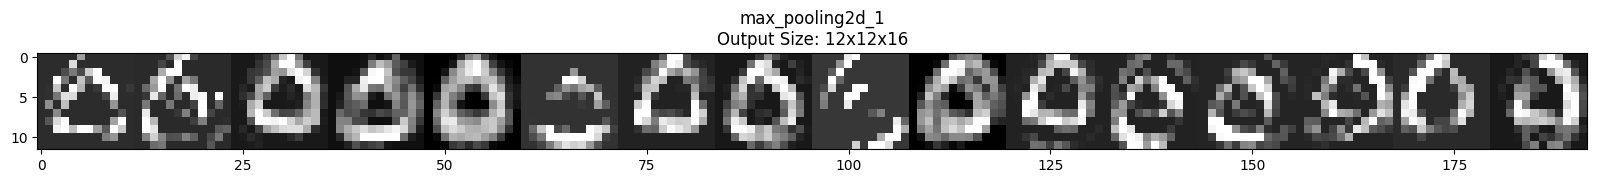

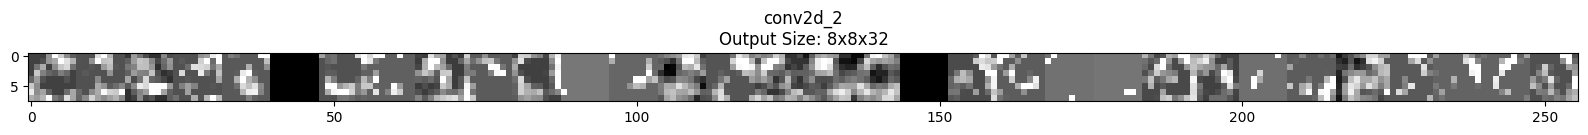

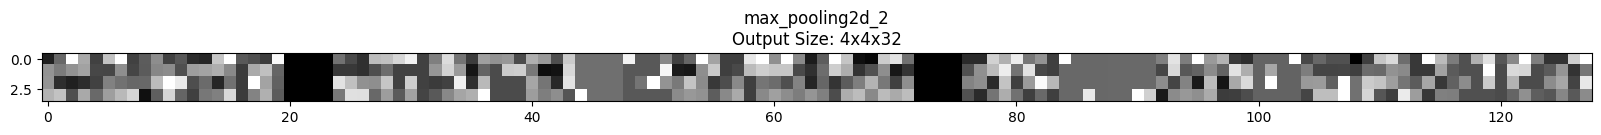

In [ ]:
import tensorflow as tf
#Select a random MNIST image from the training set
random_index = np.random.randint(0, len(x_train))
img = x_train[random_index]
plt.title('Input img')
plt.imshow(img,cmap='gray')

#Create a simple CNN model with two convolutional layers and pooling
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(28, 28, 1))) #16 kernels, 5x5 each
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))                          #32 kernels, 5x5 each
model.add(MaxPooling2D((2, 2)))


img = img.reshape((28, 28, 1))  # Add the channel dimension
img = img / 255.0  # Normalize the pixel values to [0, 1]
img = np.expand_dims(img, axis=0)  # Add the batch dimension

#Create a model to visualize feature maps
layer_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

# Get the feature maps for the example image
feature_maps = visualization_model.predict(img)

# Visualize the feature maps
layer_names = ['conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2']

# Iterate through each layer and its corresponding feature maps
for layer_name, feature_map in zip(layer_names, feature_maps):
    # Get the number of feature maps in the current layer
    n_features = feature_map.shape[-1]

    # Get the size of each feature map (assuming they are square)
    size = feature_map.shape[1]

    # Create an empty grid to display all feature maps in this layer
    display_grid = np.zeros((size, size * n_features))



    # Iterate through each feature map in the current layer
    for i in range(n_features):
        # Extract the current feature map
        x = feature_map[0, :, :, i]

        # Normalize the values for better visualization
        x -= x.mean()  # Subtract the mean value to center around 0
        x /= x.std()  # Divide by standard deviation for scaling
        x *= 64  # Scale values for better visibility
        x += 128  # Shift values to be within the [0, 255] range
        x = np.clip(x, 0, 255).astype('uint8')  # Clip values to the [0, 255] range

        # Add the current feature map to the display grid
        display_grid[:, i * size: (i + 1) * size] = x

    # Set the scale for displaying the grid
    scale = 20. / n_features

    # Create a new figure to display the feature maps for this layer
    plt.figure(figsize=(scale * n_features, scale))

    # Set the title for this layer, along with input and output size
    plt.title(f'{layer_name}\nOutput Size: {size}x{size}x{n_features}')

    # Remove grid lines for a cleaner visualization
    plt.grid(False)

    # Display the feature maps in the current layer using the viridis colormap
    plt.imshow(display_grid, aspect='auto', cmap='gray')

# Show all the visualizations
plt.show()




### Training a CNN

We add fully connected dense layers to the above model after flattening the feature maps. These dense layers will learn to classify the digit images after the convolutional and pooling layers extract features.

We one-hot encode the labels, preparing them for categorical cross-entropy loss during training. Next, the model is compiled with the Adam optimizer, categorical cross-entropy loss, and accuracy as the evaluation metric.

The model is trained on the training set for 5 epochs with a batch size of 128.

We plot the training history, including training and validation loss, and training and validation accuracy, to visualize how these metrics change over time.

Epoch 1/5
469/469 [==============================] - 66s 133ms/step - loss: 0.2622 - accuracy: 0.9235 - val_loss: 0.0777 - val_accuracy: 0.9774
Epoch 2/5
469/469 [==============================] - 48s 103ms/step - loss: 0.0715 - accuracy: 0.9785 - val_loss: 0.0518 - val_accuracy: 0.9841
Epoch 3/5
469/469 [==============================] - 46s 97ms/step - loss: 0.0494 - accuracy: 0.9848 - val_loss: 0.0392 - val_accuracy: 0.9888
Epoch 4/5
469/469 [==============================] - 49s 106ms/step - loss: 0.0396 - accuracy: 0.9880 - val_loss: 0.0378 - val_accuracy: 0.9883
Epoch 5/5
469/469 [==============================] - 44s 93ms/step - loss: 0.0328 - accuracy: 0.9899 - val_loss: 0.0325 - val_accuracy: 0.9894


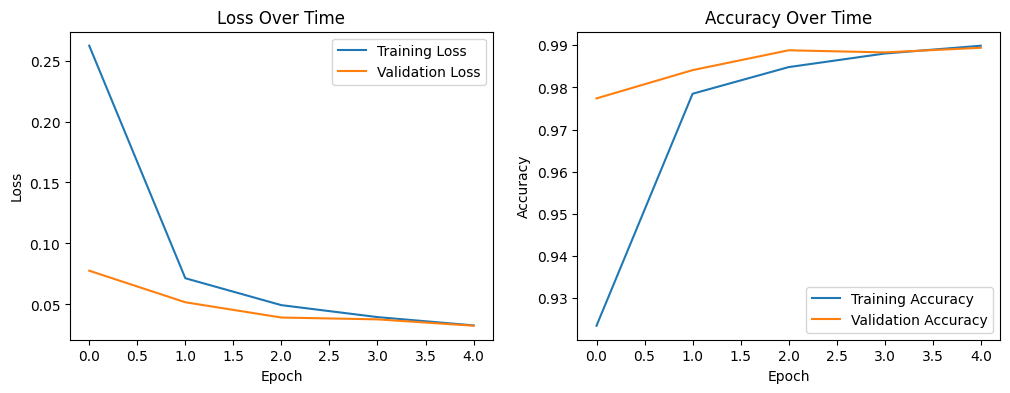

313/313 [==============================] - 4s 12ms/step - loss: 0.0325 - accuracy: 0.9894
Test Loss: 0.0325
Test Accuracy: 98.94%
313/313 [==============================] - 4s 12ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.97      0.99      0.98       892
           6       1.00      0.97      0.98       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



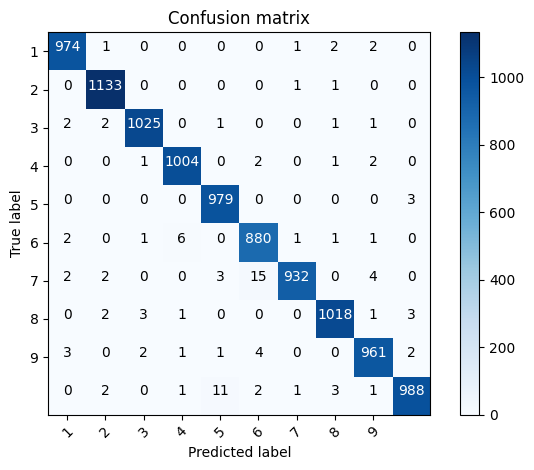

In [ ]:
#Flatten the feature maps and add fully connected dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

#encode the labels(one-hot)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


#Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=128)

#Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Time')

plt.show()

#Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

#Generate predictions
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

#Generate classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))
# print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))
plot_confusion_matrix(confusion_matrix(y_test_labels, y_pred_labels), classes=['1','2', '3', '4', '5', '6', '7', '8', '9'],
                      title='Confusion matrix')

The performance analysis on each digit class for both the training and test sets reveals a crucial aspect: the CNN achieved similar accuracy on both datasets. This indicates a successful training process and robust generalization to unseen digits. The network's ability to perform well on the test set demonstrates that it didn't overfit the training data.

We can also view the learnt kernels after the model has been trained. These are shown for the first layer below.

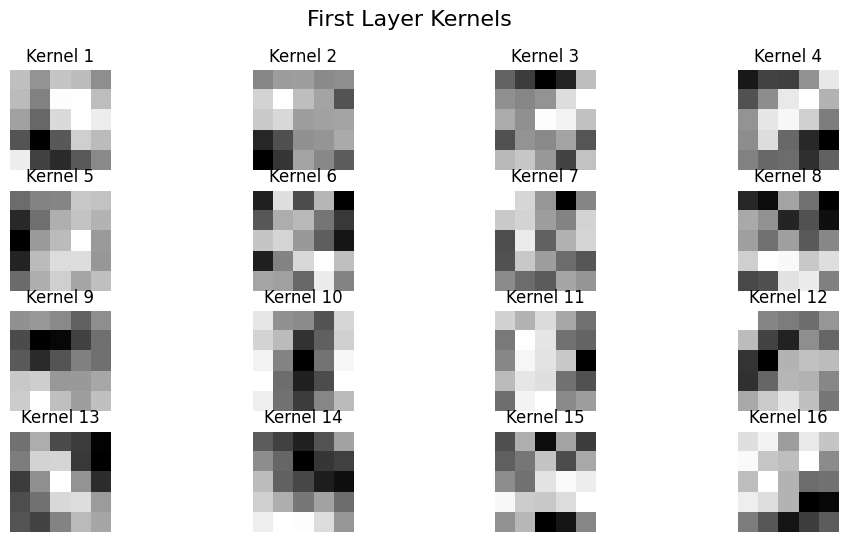

In [ ]:
first_layer_weights = model.layers[0].get_weights()[0]

#Visualize the weights
plt.figure(figsize=(12, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(first_layer_weights[:, :, 0, i], cmap='gray')
    plt.axis('off')
    plt.title(f'Kernel {i + 1}')

plt.suptitle('First Layer Kernels', fontsize=16)
plt.show()

Let us visualize a test image as it propagates through the trained model.

1/1 [==============================] - 0s 69ms/step


<ipython-input-9-7fb1881253c6>:32: RuntimeWarning: invalid value encountered in divide
  feature_map_i /= feature_map_i.std()  # Divide by standard deviation for scaling


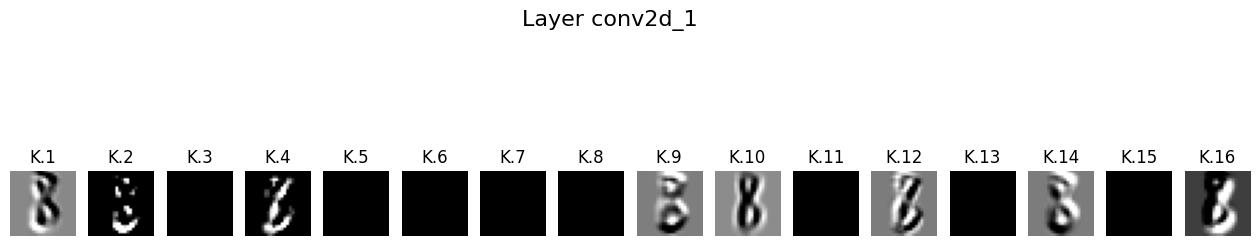

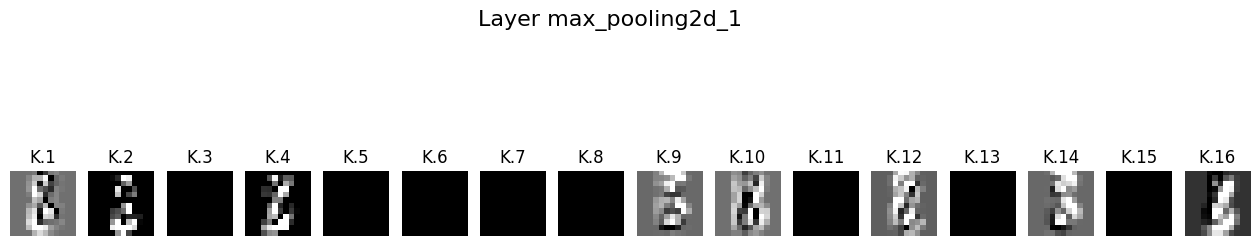

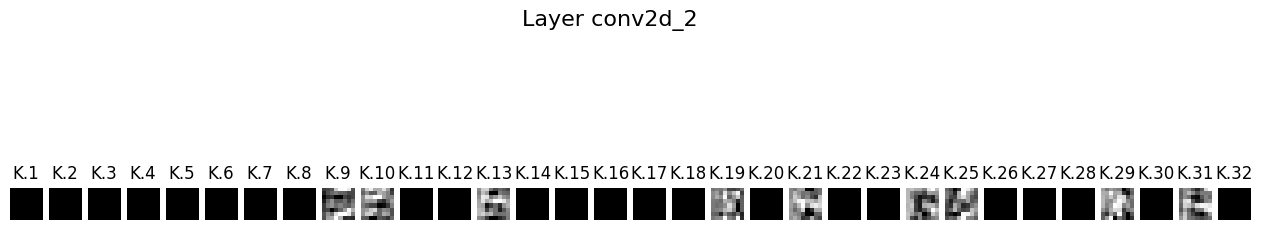

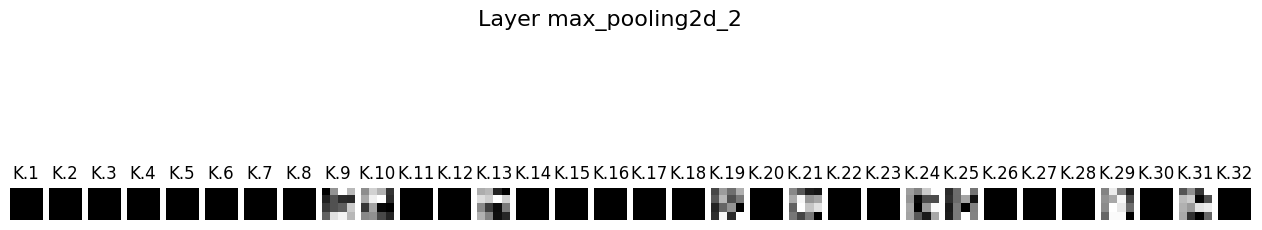

In [ ]:
#Select a random MNIST image from the test set
random_index = np.random.randint(0, len(x_test))
test_image = x_test[random_index]

#Preprocess the test image for visualization
test_image = test_image / 255.0
test_image = np.expand_dims(test_image, axis=0)

#Extract the parameters from the trained model and create a visualization model with these
layer_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

#Get the feature maps for the test image
feature_maps = visualization_model.predict(test_image)

#Visualize the feature maps at different layers
layer_names = ['conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2']

for layer_name, feature_map in zip(layer_names, feature_maps):
    # Get the number of feature maps in the current layer
    n_features = feature_map.shape[-1]

    # Create a new figure to display the feature maps for this layer
    plt.figure(figsize=(16, 4))

    # Visualize feature maps for each kernel in the current layer
    for i in range(n_features):
        feature_map_i = feature_map[0, :, :, i]

        # Normalize the values for better visualization
        feature_map_i -= feature_map_i.mean()  # Subtract the mean value to center around 0
        feature_map_i /= feature_map_i.std()  # Divide by standard deviation for scaling
        feature_map_i *= 64  # Scale values for better visibility
        feature_map_i += 128  # Shift values to be within the [0, 255] range
        feature_map_i = np.clip(feature_map_i, 0, 255).astype('uint8')  # Clip values to the [0, 255] range

        # Create subplots for each feature map
        plt.subplot(1, n_features, i + 1)
        plt.imshow(feature_map_i, cmap='gray')
        plt.axis('off')
        plt.title(f'K.{i + 1}')

    plt.suptitle(f'Layer {layer_name}', fontsize=16)
    plt.show()



## Working of layers

Here, we can see that the output for first layer has 16 kernels out of which kernel 1, 2, 3, 14, and 16 work together to give an intuition of horizontal and vertical orientation of the of the lines.

While kernel 8 and 13 extract vertical and horizontal edges. Which are used for defining the numbers and these edges can be used with the kernels mentioned above to figure out which number might be present.

In max pool layer it just samples down the output of the kernal and adds shift invariance while training the model.

For layer 2 it gets harder to intuitively explain what the kernels are doing what exactly. But, we know that the first layer was mostly extracting the edges orientation and position. This layer should be extracting the relative distances and relative orientation of these edges. Since, the receptive field for layer 2 is more it should be able to "see" more pixels. Making a better spatial representation of the digits.

After we obtain the relative information of the edges and their orientation. We used a fully connected and then a softmax layer. Which would have learnt which feature or which orientation of the edges correspond to which digit.

## Testing the model
We will be testing the model by using an image from the 'train' set to demonstrate if the model has trained correctly or not.

1/1 [==============================] - 0s 19ms/step
Prediction:  [2]


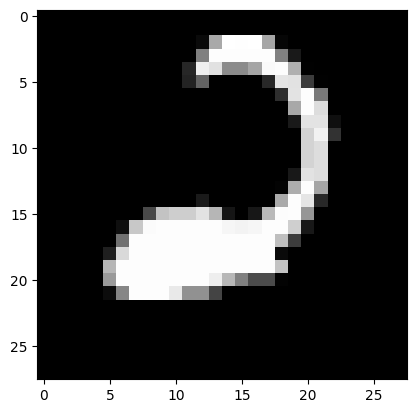

In [ ]:
#Select a random MNIST image from the test set
random_index = np.random.randint(0, len(x_test))
test_img = x_test[random_index]

#Preprocess the test image for visualization
test_image = test_img / 255.0
test_image = np.expand_dims(test_image, axis=0)
prediction = model.predict(test_image)

print('Prediction: ', np.argmax(prediction, axis=1))

plt.imshow(test_img,cmap='gray')

We can see that the model works nicely for this test test image taken at random

## Testing the model on my digits
I uploaded a image of a digit that I draw and will be using google drive to access the image.

In [ ]:
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img.shape

(28, 28, 3)

1/1 [==============================] - 0s 126ms/step
The prediction made by the model is 2


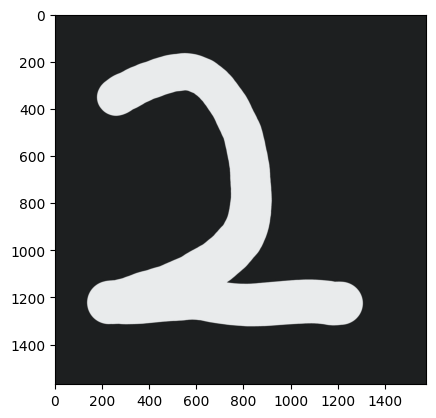

In [ ]:
img_og = cv2.imread("/content/drive/MyDrive/IP_image.jpg")
img = cv2.cvtColor(img_og, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (28, 28))
img = img.reshape((1, 28, 28))
# cv2_imshow(img)
pred = model.predict(img)
print("The prediction made by the model is", np.argmax(pred))
plt.imshow(img_og)

## Using SIFT to on MNIST dataset

I used SIFT to find the keypoints of the image (Features) which are then compared for two seperate images. The observations are mentioned below this as well.

In [ ]:
# Keeping the digit to be one
# rand_ind = np.random.randint(0, len(x_test))
print("The digit will be ",np.argmax(y_test[3709]), 'for test and ', np.argmax(y_train[9114]), 'for train')

The digit will be  9 for test and  9 for train


FEATURES DETECTED


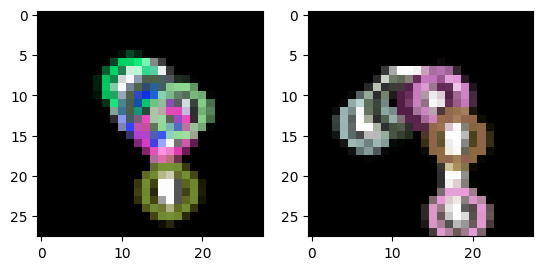

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
image_1 = x_train_og[9114]
image_2 = x_test_og[3709]

sift = cv2.SIFT.create()
# For training image
keyPoints_1 = sift.detect(image_1, None)

output_1 = cv2.drawKeypoints(image_1, keyPoints_1, None)

#For test  image
keyPoints_2 = sift.detect(image_2, None)

output_2 = cv2.drawKeypoints(image_2, keyPoints_2, None)
# Display image
print("FEATURES DETECTED")
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(output_1, cmap="gray")
ax2.imshow(output_2, cmap="gray")
plt.show()

Here we can see that the keypoints are checking similar features for both the images.

For this example it is checking the stem of digit "9" and the junction point of "o"(head) of the digit "9" and its other features.

## Testing the same architecture on CIFAR-10 Dataset

In [ ]:
labels = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

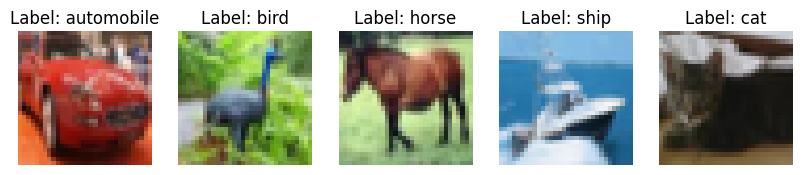

In [ ]:
#Load the CIFAR-10 dataset and preprocess it
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# x_train = x_train_c.reshape((-1, 28, 28, 1))
# x_test = x_test_c.reshape((-1, 28, 28, 1))
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


#Display a few sample images
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i+5], cmap='gray')
    plt.title(f"Label: {labels[y_train[i+5,0]]}")
    plt.axis('off')
plt.show()

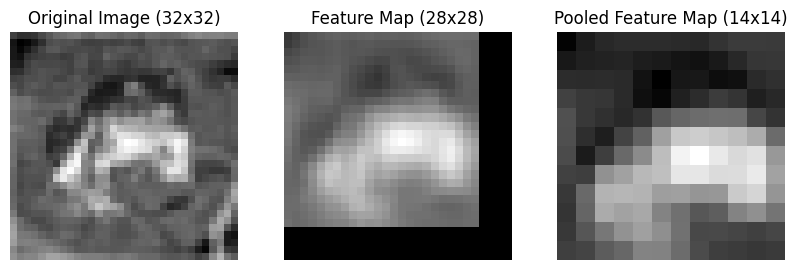

In [ ]:
image = x_train[0]
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Create a random 5x5 receptive field
receptive_field = np.random.rand(5, 5)

feature_map = np.zeros((28, 28))  # Output feature map size after convolution (32-5+1)x(32-5+1)

for i in range(24):
    for j in range(24):
        feature_map[i, j] = np.sum(image[i:i+5, j:j+5] * receptive_field) #Perform convolution

#Perform max-pooling with a 2x2 neighborhood
pooled_feature_map = np.zeros((12, 12))

for i in range(0, 24, 2):
    for j in range(0, 24, 2):
        pooled_feature_map[i//2, j//2] = np.max(feature_map[i:i+2, j:j+2])

#Visualize the image, feature map, and pooled feature map
plt.figure(figsize=(10, 4))

plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title("Original Image (32x32)")
plt.axis('off')

plt.subplot(132)
plt.imshow(feature_map, cmap='gray')
plt.title("Feature Map (28x28)")
plt.axis('off')

plt.subplot(133)
plt.imshow(pooled_feature_map, cmap='gray')
plt.title("Pooled Feature Map (14x14)")
plt.axis('off')

plt.show()


1/1 [==============================] - 0s 56ms/step


<ipython-input-220-ad4682105182>:53: RuntimeWarning: invalid value encountered in divide
  x /= x.std()  # Divide by standard deviation for scaling


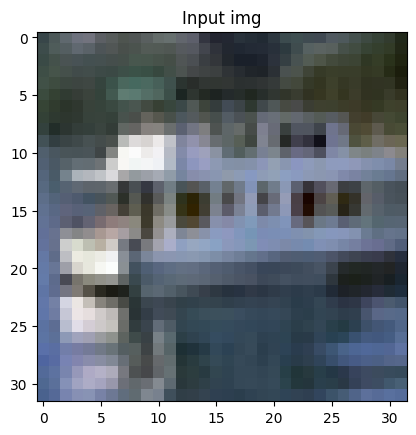

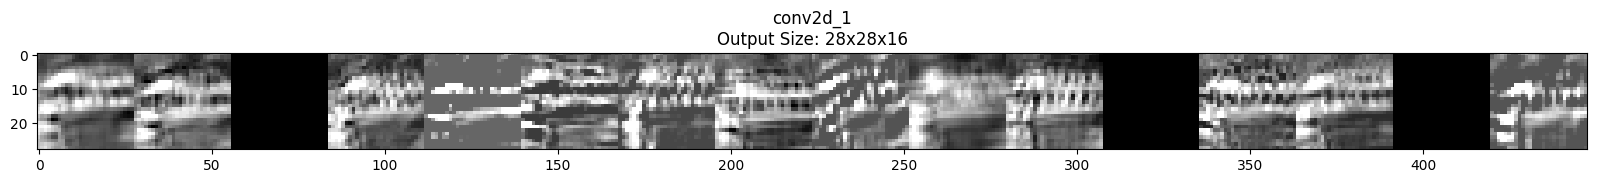

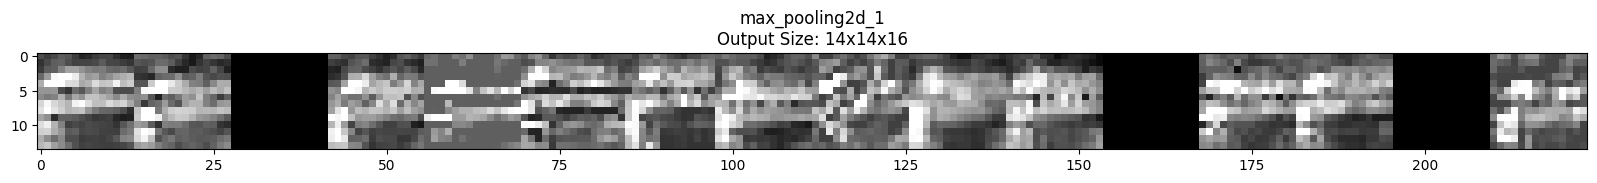

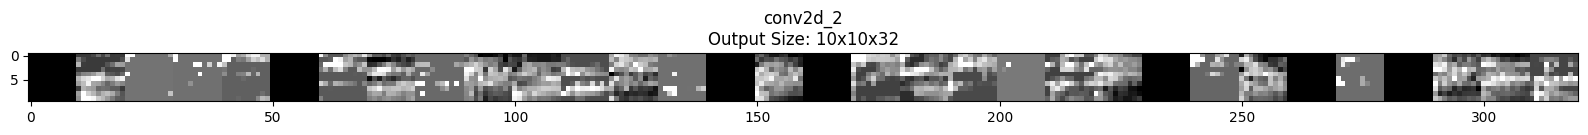

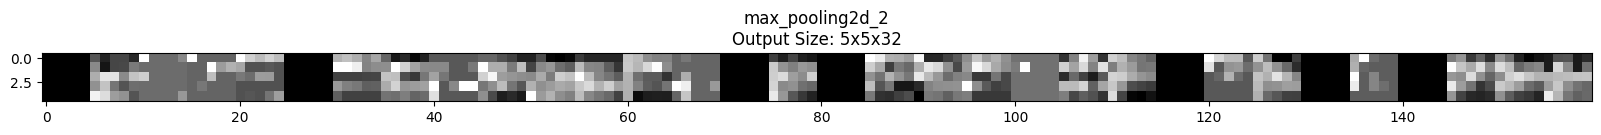

In [ ]:
import tensorflow as tf
#Select a random MNIST image from the training set
random_index = np.random.randint(0, len(x_train))
img = x_train[random_index]
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.title('Input img')
plt.imshow(img,cmap='gray')

#Create a simple CNN model with two convolutional layers and pooling
model = Sequential()
  #  model.add(Conv2D(16, (3, 3), input_shape=(32, 32, 3), padding='same'))
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(32, 32, 3))) #16 kernels, 5x5 each
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))                          #32 kernels, 5x5 each
model.add(MaxPooling2D((2, 2)))


img = img.reshape((32, 32, 3))  # Add the channel dimension
img = img / 255.0  # Normalize the pixel values to [0, 1]
img = np.expand_dims(img, axis=0)  # Add the batch dimension

#Create a model to visualize feature maps
layer_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

# Get the feature maps for the example image
feature_maps = visualization_model.predict(img)

# Visualize the feature maps
layer_names = ['conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2']

# Iterate through each layer and its corresponding feature maps
for layer_name, feature_map in zip(layer_names, feature_maps):
    # Get the number of feature maps in the current layer
    n_features = feature_map.shape[-1]

    # Get the size of each feature map (assuming they are square)
    size = feature_map.shape[1]

    # Create an empty grid to display all feature maps in this layer
    display_grid = np.zeros((size, size * n_features))



    # Iterate through each feature map in the current layer
    for i in range(n_features):
        # Extract the current feature map
        x = feature_map[0, :, :, i]

        # Normalize the values for better visualization
        x -= x.mean()  # Subtract the mean value to center around 0
        x /= x.std()  # Divide by standard deviation for scaling
        x *= 64  # Scale values for better visibility
        x += 128  # Shift values to be within the [0, 255] range
        x = np.clip(x, 0, 255).astype('uint8')  # Clip values to the [0, 255] range

        # Add the current feature map to the display grid
        display_grid[:, i * size: (i + 1) * size] = x

    # Set the scale for displaying the grid
    scale = 20. / n_features

    # Create a new figure to display the feature maps for this layer
    plt.figure(figsize=(scale * n_features, scale))

    # Set the title for this layer, along with input and output size
    plt.title(f'{layer_name}\nOutput Size: {size}x{size}x{n_features}')

    # Remove grid lines for a cleaner visualization
    plt.grid(False)

    # Display the feature maps in the current layer using the viridis colormap
    plt.imshow(display_grid, aspect='auto', cmap='gray')

# Show all the visualizations
plt.show()


In [ ]:
x_train.shape

In [ ]:
print("shape of the image", type(x_train))
plt.imshow(x_train[0])

Epoch 1/5
391/391 [==============================] - 4s 8ms/step - loss: 1.7110 - accuracy: 0.3786 - val_loss: 1.5083 - val_accuracy: 0.4644
Epoch 2/5
391/391 [==============================] - 2s 6ms/step - loss: 1.4026 - accuracy: 0.4974 - val_loss: 1.3371 - val_accuracy: 0.5231
Epoch 3/5
391/391 [==============================] - 2s 6ms/step - loss: 1.2906 - accuracy: 0.5408 - val_loss: 1.2975 - val_accuracy: 0.5387
Epoch 4/5
391/391 [==============================] - 3s 7ms/step - loss: 1.2095 - accuracy: 0.5741 - val_loss: 1.1918 - val_accuracy: 0.5812
Epoch 5/5
391/391 [==============================] - 2s 6ms/step - loss: 1.1453 - accuracy: 0.6001 - val_loss: 1.1305 - val_accuracy: 0.6058


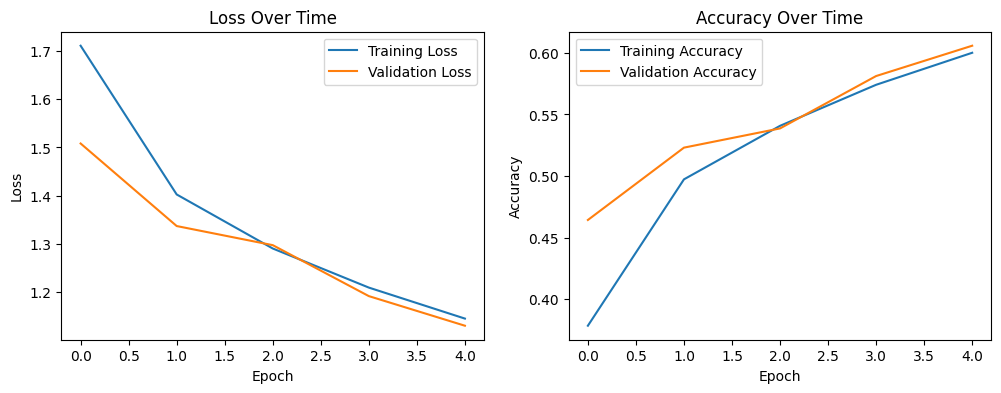

313/313 [==============================] - 1s 4ms/step - loss: 1.1305 - accuracy: 0.6058
Test Loss: 1.1305
Test Accuracy: 60.58%
313/313 [==============================] - 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.64      0.66      1000
           1       0.77      0.66      0.71      1000
           2       0.48      0.41      0.44      1000
           3       0.46      0.42      0.44      1000
           4       0.48      0.61      0.53      1000
           5       0.52      0.52      0.52      1000
           6       0.65      0.72      0.68      1000
           7       0.65      0.68      0.66      1000
           8       0.73      0.70      0.72      1000
           9       0.66      0.70      0.68      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



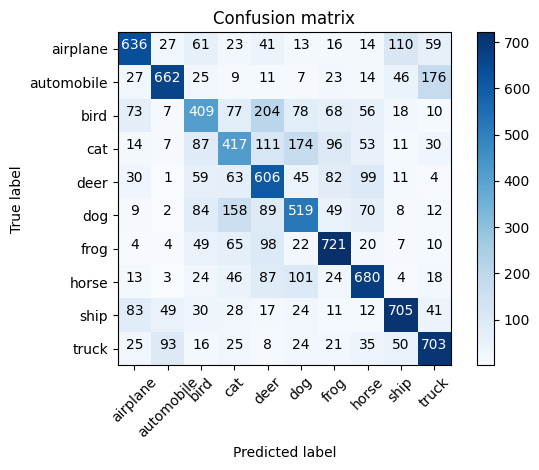

In [ ]:
#Flatten the feature maps and add fully connected dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

#encode the labels(one-hot)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
#Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=128)

#Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Time')

plt.show()

#Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

#Generate predictions
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

#Generate classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))
# print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))
plot_confusion_matrix(confusion_matrix(y_test_labels, y_pred_labels), labels,
                      title='Confusion matrix')

In [ ]:
rand_ind = np.random.randint(0, len(x_test))
img = x_test[rand_ind]

#Preprocess the test image for visualization
test_image = img / 255.0
test_image = np.expand_dims(test_image, axis=0)
prediction = model.predict(test_image)
print(prediction)

1/1 [==============================] - 0s 20ms/step
[[0.20177439 0.02434958 0.0601567  0.45577356 0.08436134 0.03899428
  0.04471344 0.04920947 0.03583682 0.00483052]]


In [ ]:
rand_ind = np.random.randint(0, len(x_test))
img = x_test[rand_ind]

#Preprocess the test image for visualization
img = img / 255.0
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)


print("Predicted", labels[np.argmax(prediction)], "while the actual label was", labels[np.argmax(y_test[rand_ind])])

1/1 [==============================] - 0s 22ms/step
Predicted cat while the actual label was cat


## References Used:
[1] https://en.wikipedia.org/wiki/CIFAR-10

[2] https://colab.research.google.com/github/agmarrugo/computer-vision-utb/blob/main/notebooks/sift.ipynb#scrollTo=eR9WK3FOmvIS

[3] https://colab.research.google.com/github/Askinkaty/IntroDL/blob/master/CNN_on_CIFAR_10.ipynb#scrollTo=Iy5XYkYImTbe

[4] https://colab.research.google.com/github/jfogarty/machine-learning-intro-workshop/blob/master/notebooks/plot_confusion_matrix.ipynb#scrollTo=y1valzYbG5_p